# GDAL

In [1]:
%matplotlib inline 
import pylab as pl
from osgeo import gdal, ogr, osr
import os
import numpy as np 

## Lectura de un raster

In [30]:
#Se debe abrir la lectura 
Raster = gdal.Open('dem_tenche.tif')
Projection = Raster.GetProjection() 
# Lee los datos del raster
Transform = Raster.GetGeoTransform()
x  = Raster.GetGeoTransform()[0]    # Origen
y  = Raster.GetGeoTransform()[3]    # Origen
dx = Raster.GetGeoTransform()[1]    # Cellsize
dy = -1*Raster.GetGeoTransform()[5] # Cellsize
# Lee numero de columnas y filas
cols = Raster.RasterXSize                
rows = Raster.RasterYSize           
#toma la primera banda (pueden ser varias)           
rast = Raster.GetRasterBand(1)	       # Bandas
noData = rast.GetNoDataValue()	       
#Lee datos
DEM = rast.ReadAsArray()	             # Lee como array 
DEM = DEM.astype(float)
DEM[DEM == noData] = np.nan 
DEMmask = np.ma.array(DEM, mask=np.isnan(DEM))

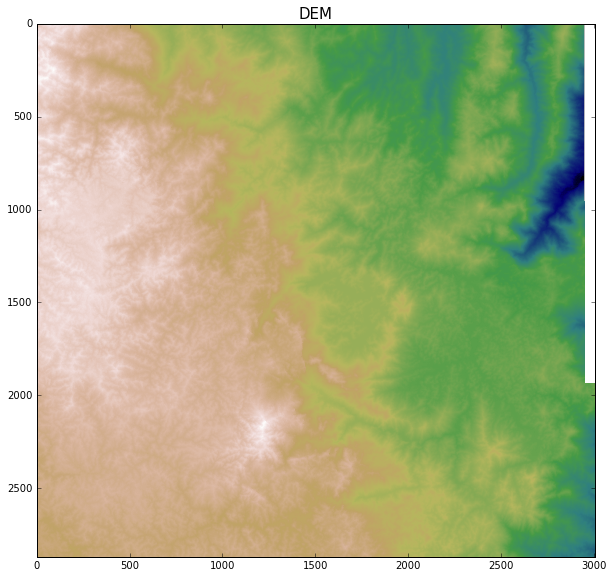

In [39]:
fig=pl.figure('Raster 1', facecolor= 'white', figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.set_title('DEM', size=15)
pl.subplots_adjust(bottom=0.15)
pl.imshow(DEMmask,cmap='gist_earth')
pl.subplots_adjust(bottom=0.15)

Hasta este punto el raster puede ya ser tratado como un array de numpy, por lo que podemos hacer cualquier operación sobre el mismo, de igual manera podemos volverlo a escribir en formato Raster para ser leido por un SIG.

## Aspectos sobre un raster:

Un archivo raster contiene datos e información sobre su localización (independiente del formato).  De forma adicional, dependiendo del formato puede contener múltiples capas.  Y en términos de localización debe contener información sobre coordenadas y su $\Delta x$.

**Información base de raster**:

- xll: coordenada X de la celda localizada en la esquina izquierda baja.
- yll: coordenada Y de la celda localizada en la esquina izquierda baja.
- $\Delta x$: Tamaño de la celda en X.
- $\Delta y$: Tamaño de la celda en Y.
- ncols: Cantidad de columnas (o entradas en X).
- nrows: Cantidad de filas (o entradas en Y).
- noData: Valor que representa los datos nulos (generalmente transparentes en un GIS).

## Ejercicio 1: 

Teniendo en cuenta lo anterior, haga un algoritmo que obtenga en dos matrices las coordenadas X y Y del raster que ha leido. Use sus habilidades y la función **np.meshgrid** para lograrlo!.

## Ejercicio 2:

Vamos a tomar una porción del raster y vamos a iterar sobre este con una ventana de 3x3, esta ventana va a escribir en una nueva matriz el promedio de los valores, la ventana debe ser centrada.

## Ejercicio 3:

Cálculo de mapa de pendientes: nuevamente vamos a evaluar sólo una porción del raster (por efectos de velocidad). en este caso nuevamente vamos a pasar una ventana de 3x3 y en cada iteración se va a buscar el vecino con mayor pendiente, hacia esta celda es donde se supone que drena la mayor parte del agua, por lo tanto la pendiente dominante es la que se ubica hacia esta celda, calculemos entonces la pendiente con respecto a esta celda destino.

- Nota 1: Si 2 o más vecinos tiene la misma elevación elija de alguna manera el vecino al que drena.
- Nota 2: Si todos los vecinos tienen la misma elevación, y esta es igual a la celda evaluada,  la pendiente es cero.
- Nota 3: Si todos los vecinos tienen una elevación mayor a la celda evaluada marque la pendiente con respecto al vecnio de mayor elevación y denotela con un número negativo.

## Escritura de un Raster

Escribir un raster no es tan trivial como leerlo, ya que es necesario especificar los diferentes parámetros del mismo, a continuación se presenta una función que permite escribir un raster cualquiera, esta requiere de:

- Un array (el raster).
- Las propiedades del raster.
- La ruta de escritura.
- El tipo de sistema de coordenadas que se va a usar para escribir el raster.
- El formato en el cual será escrito el raster.

Las propiedades del raster se encuentran denotadas dentro de una array y este debe llevar las propiedades en la siguiente estructura:

1. ncols: Cantidad de columnas del array.
1. nrows: cantidad de filas del array.
1. Xll: Coordenada en el extremo inferior izquierdo.
1. yll: Coordenada en el extremo inferior izquierdo.
1. noData: valor que corresponde a las celdas nulas.

In [15]:
def Save_Array2Raster(Array, ArrayProp, ruta, EPSG = 4326, Format = 'GTiff'):
    dst_filename = ruta
    #Formato de condiciones del mapa
    x_pixels = Array.shape[0]  # number of pixels in x
    y_pixels = Array.shape[1]  # number of pixels in y
    PIXEL_SIZE = ArrayProp[4]  # size of the pixel...        
    x_min = ArrayProp[2]  
    y_max = ArrayProp[3] + ArrayProp[4] * ArrayProp[1] # x_min & y_max are like the "top left" corner.
    driver = gdal.GetDriverByName(Format)
    #Para encontrar el formato de GDAL 
    NP2GDAL_CONVERSION = {
      "uint8": 1,
      "int8": 1,
      "uint16": 2,
      "int16": 3,
      "uint32": 4,
      "int32": 5,
      "float32": 6,
      "float64": 7,
      "complex64": 10,
      "complex128": 11,
    }
    gdaltype = NP2GDAL_CONVERSION[Array.dtype.name]
    # Crea el driver
    dataset = driver.Create(
        dst_filename,
        x_pixels,
        y_pixels,
        1,
        gdaltype,)
    #coloca la referencia espacial
    dataset.SetGeoTransform((
        x_min,    # 0
        PIXEL_SIZE,  # 1
        0,                      # 2
        y_max,    # 3
        0,                      # 4
        -PIXEL_SIZE))  
    #coloca la proyeccion a partir de un EPSG
    proj = osgeo.osr.SpatialReference()
    texto = 'EPSG:' + str(EPSG)
    proj.SetWellKnownGeogCS( texto )
    dataset.SetProjection(proj.ExportToWkt())
    #Coloca el nodata
    band = dataset.GetRasterBand(1)
    if ArrayProp[-1] == None:        
        band.SetNoDataValue(wmf.cu.nodata.astype(int).max())
    else:
        band.SetNoDataValue(-9999)
    #Guarda el mapa
    dataset.GetRasterBand(1).WriteArray(Array.T)
    dataset.FlushCache() 

## Ejercicio 3:

Teniendo en cuenta lo anterior y los resultados obtenidos en el **ejercicio 1**, obtenga las propiedades necesarias para guardar el array que ha obtenido en un raster que sea legible por un SIG.

___
# Vector 

Todo lo vectorial se maneja con la libreria **osgeo.ogr** y **osgeo.osr**.

Primero vamos a explorar un poco como es la lectura de este tipo de elementos, luego podremos ver cómo se pueden leer sus atributos y pasarlos a alementos tipo array para posteriormente hacer cálculos con ellos.

In [16]:
def read_map_points(ruta_map, ListAtr = None):
    #Obtiene el acceso
    dr = osgeo.ogr.Open(ruta_map)
    l = dr.GetLayer()
    #Lee las coordenadas
    Cord = []
    for i in range(l.GetFeatureCount()):
        f = l.GetFeature(i)
        g = f.GetGeometryRef()
        pt = [g.GetX(),g.GetY()]
        Cord.append(pt)
    Cord = np.array(Cord).T
    #Si hay atributos para buscar los lee y los m
    if ListAtr is not None:
        Dict = {}
        for j in ListAtr:
            #Busca si el atributo esta
            pos = f.GetFieldIndex(j)
            #Si esta lee la info del atributo
            if pos is not -1:
                vals = []
                for i in range(l.GetFeatureCount()):
                    f = l.GetFeature(i)
                    vals.append(f.GetField(pos))
                Dict.update({j:np.array(vals)})
        #Cierra el mapa 
        dr.Destroy()
        return Cord, Dict
    else:
        #Cierra el mapa 
        dr.Destroy()
        return Cord

## Ejercicio 4:

Interpolación con IDW, suponiendo que el vector de Coordenadas.shp contiene datos de precipitación, podríamos obtener un campo de precipitación interpolado para una porción del DEM que estamos analizando.  